In [202]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from gensim.models import FastText
from nltk.tokenize import word_tokenize
import nltk
import re
from lemmatizator import lemmatize
import matplotlib.pyplot as plt

In [203]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [204]:
def preproc_doc(doc_series):
    p_corpus = []
    for doc in doc_series:
        doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
        doc = doc.lower().strip()
        tokens = wpt.tokenize(doc)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        cleaned_text = ' '.join(filtered_tokens)
        p_corpus.append(lemmatize(cleaned_text))
    return p_corpus

In [205]:
df = pd.read_csv("documents1.csv")
corpus = df["Text"]
labels = df["Label"]
corpus = preproc_doc(corpus)

In [206]:
train_corpus, test_corpus, train_labels, test_labels = train_test_split(corpus, labels, test_size=0.2, random_state=42)

In [207]:
labels.value_counts()

Label
1    255
4    255
0    208
2    201
3    193
Name: count, dtype: int64

In [208]:
# TF-IDF 
tfidf_vectorizer = TfidfVectorizer()
corpus_train_tfidf = tfidf_vectorizer.fit_transform(train_corpus)
corpus_test_tfidf = tfidf_vectorizer.transform(test_corpus)

In [209]:
# FastText
train_sentences = [word_tokenize(text) for text in train_corpus]
fasttext_model = FastText(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

In [210]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros(num_features, dtype=np.float64)
    nwords = 0
    for word in words:
        if word in vocabulary:
            feature_vector += model.wv[word]
            nwords += 1
    return feature_vector / nwords if nwords > 0 else feature_vector

def document_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    return np.array([average_word_vectors(word_tokenize(doc), model, vocabulary, num_features) for doc in corpus])

In [211]:
corpus_train_fasttext = document_vectorizer(train_corpus, fasttext_model, 100)
corpus_test_fasttext = document_vectorizer(test_corpus, fasttext_model, 100)

In [212]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=10, random_state=42)
}

In [213]:
# Hyperparameters for GridSearchCV
param_grid = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "Random Forest": {"n_estimators": [50, 100, 200]}
}

In [214]:
results = {}

            Classifier   Feature  Accuracy  Accuracy (GridSearchCV)
0  Logistic Regression    TF-IDF  0.986547                 0.995516
1  Logistic Regression  FastText  0.946188                 0.955157


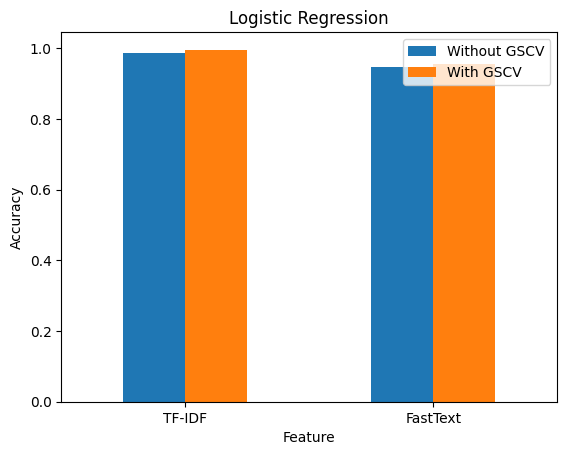

      Classifier   Feature  Accuracy  Accuracy (GridSearchCV)
0  Random Forest    TF-IDF  0.878924                 0.964126
1  Random Forest  FastText  0.955157                 0.968610


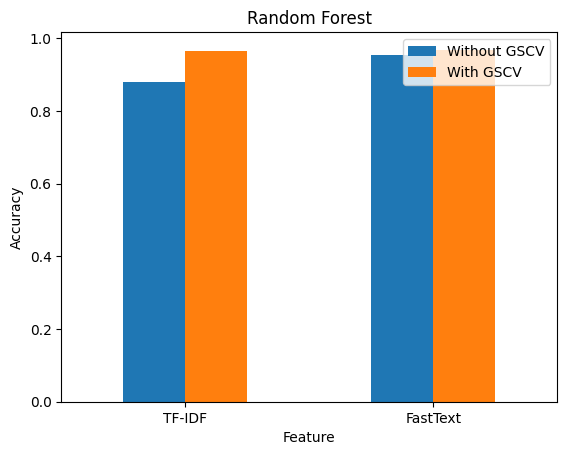

In [215]:
for name, clf in classifiers.items():
    features = {
        "TF-IDF": (corpus_train_tfidf, corpus_test_tfidf),
        "FastText": (corpus_train_fasttext, corpus_test_fasttext)
    }
    
    acc_data = []
    
    for feature_name, (train_feat, test_feat) in features.items():
        # With GridSearchCV
        clf.fit(train_feat, train_labels)
        label_pred = clf.predict(test_feat)
        acc = accuracy_score(test_labels, label_pred)
        results[f"{name} + {feature_name}"] = acc
        
        # Without GridSearchCV
        grid_search = GridSearchCV(clf, param_grid[name], cv=3, scoring='accuracy')
        grid_search.fit(train_feat, train_labels)
        best_clf = grid_search.best_estimator_
        label_pred_grid = best_clf.predict(test_feat)
        acc_grid = accuracy_score(test_labels, label_pred_grid)
        results[f"{name} + {feature_name} + GridSearchCV"] = acc_grid
        
        acc_data.append([name, feature_name, acc, acc_grid])
    
    df = pd.DataFrame(acc_data, columns=["Classifier", "Feature", "Accuracy", "Accuracy (GridSearchCV)"])
    print(df)
    
    df.plot(x="Feature", y=["Accuracy", "Accuracy (GridSearchCV)"], kind="bar", title=name)
    plt.ylabel("Accuracy")
    plt.xticks(rotation=0)
    plt.legend(["Without GSCV", "With GSCV"])
    plt.show()


In [216]:
texts = [
"The foreign minister embarked on a crucial diplomatic mission today, traveling to the neighboring country to address escalating tensions along their shared border. This visit comes after weeks of heightened rhetoric and military build-up on both sides, raising concerns about a potential conflict in the region. The minister's agenda includes a series of high-level meetings with their counterpart and the head of state, where they will aim to de-escalate the situation through dialogue and negotiation. Key discussion points are expected to include border demarcation, the withdrawal of troops from sensitive areas, and the establishment of a joint monitoring mechanism. The international community is closely watching these developments, hoping for a peaceful resolution to the crisis that could have significant geopolitical implications.",
    
"The atmosphere at the stadium was electric as the two top-ranked teams clashed in the final of the prestigious international soccer tournament. Millions of fans around the globe tuned in to witness what was anticipated to be a closely contested match filled with skill and drama. The first half saw both sides create several scoring opportunities, but neither could break the deadlock, leading to a tense and tactical battle in midfield. The second half brought a flurry of action, with a controversial penalty decision sparking heated debate among players and spectators. Ultimately, it was a moment of individual brilliance from a star striker in the dying minutes of the game that sealed the victory for their team, triggering wild celebrations on the pitch and in the stands.",
    
"At a special presentation held this morning, the technology giant unveiled its newest smartphone, which, according to company representatives, is a true breakthrough in mobile technology. The device is equipped with a revolutionary processor that provides unprecedented speed and energy efficiency. Among the key features are an improved camera with artificial intelligence, an ultra-clear display with HDR support, as well as integrated next-generation security features. In addition, the smartphone boasts an elegant design and is made from high-quality materials. The novelty is expected to go on sale next month and will pose serious competition to other flagship models on the market.",
    
"Movie fans are eagerly awaiting the release of the highly anticipated film, which is scheduled to premiere next month. This picture, which combines elements of science fiction and adventure, tells a captivating story about time travel and dangerous missions. The film was directed by a renowned master of the genre, and the main roles were played by world-famous stars. Judging by the trailers and early reviews from critics, viewers can expect a visually stunning and emotionally charged cinematic journey. The film is expected to become one of the highest-grossing films of the year and receive numerous awards.",
    
"In its latest financial report, a large industrial company announced a significant increase in profits for the current quarter. According to the data presented, the company's net profit increased by 15% compared to the same period last year. The company's management attributes the positive trend to the successful launch of new products, the optimization of production processes, and expansion into new markets. This trend is expected to continue in the coming quarters, which will allow the company to strengthen its market position and increase investment in further development. Investors reacted positively to this news, which led to an increase in the company's stock price on the stock exchange."
]

In [217]:
corpus_test_fasttext_for_text = document_vectorizer(preproc_doc(texts), fasttext_model, 100)

In [218]:
preprocessed_texts = preproc_doc(texts)
corpus_test_tfidf_for_text = tfidf_vectorizer.transform(preprocessed_texts)

In [219]:
lg1 = LogisticRegression(max_iter=1000)
lg1.fit(corpus_train_fasttext, train_labels)
label_pred = lg1.predict(corpus_test_fasttext_for_text)
label_pred

array([0, 1, 2, 3, 4])

In [220]:
lg2 = RandomForestClassifier(n_estimators=10, random_state=42)
lg2.fit(corpus_train_fasttext, train_labels)
label_pred = lg2.predict(corpus_test_fasttext_for_text)
label_pred

array([0, 1, 2, 3, 4])

In [221]:
rfc1 = LogisticRegression(max_iter=1000)
rfc1.fit(corpus_train_tfidf, train_labels)
label_pred = rfc1.predict(corpus_test_tfidf_for_text)
label_pred

array([4, 1, 2, 3, 4])

In [222]:
rfc2 = RandomForestClassifier(n_estimators=10, random_state=42)
rfc2.fit(corpus_train_tfidf, train_labels)
label_pred = rfc2.predict(corpus_test_tfidf_for_text)
label_pred

array([0, 1, 4, 3, 4])

In [223]:
param_grid_lg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_lg1 = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lg, cv=3, scoring='accuracy')
grid_search_lg1.fit(corpus_train_fasttext, train_labels)
best_lg1 = grid_search_lg1.best_estimator_
label_pred_lg1_grid = best_lg1.predict(corpus_test_fasttext_for_text)

print("The best hyperparameters for lg1 (FastText):", grid_search_lg1.best_params_)
label_pred_lg1_grid

The best hyperparameters for lg1 (FastText): {'C': 100}


array([4, 1, 2, 3, 4])

In [224]:
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
grid_search_lg2 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
grid_search_lg2.fit(corpus_train_fasttext, train_labels)
best_lg2 = grid_search_lg2.best_estimator_
label_pred_lg2_grid = best_lg2.predict(corpus_test_fasttext_for_text)

print("\nThe best hyperparameters for lg2 (FastText):", grid_search_lg2.best_params_)
label_pred_lg2_grid


The best hyperparameters for lg2 (FastText): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


array([0, 1, 2, 3, 4])

In [225]:
param_grid_rfc1 = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_rfc1 = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_rfc1, cv=3, scoring='accuracy')
grid_search_rfc1.fit(corpus_train_tfidf, train_labels)
best_rfc1 = grid_search_rfc1.best_estimator_
label_pred_rfc1_grid = best_rfc1.predict(corpus_test_tfidf_for_text)

print("\nThe best hyperparameters for rfc1 (TF-IDF):", grid_search_rfc1.best_params_)
label_pred_rfc1_grid


The best hyperparameters for rfc1 (TF-IDF): {'C': 100}


array([0, 1, 2, 3, 4])

In [226]:
param_grid_rfc2 = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
grid_search_rfc2 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rfc2, cv=3, scoring='accuracy')
grid_search_rfc2.fit(corpus_train_tfidf, train_labels)
best_rfc2 = grid_search_rfc2.best_estimator_
label_pred_rfc2_grid = best_rfc2.predict(corpus_test_tfidf_for_text)

print("\nThe best hyperparameters for rfc2 (TF-IDF):", grid_search_rfc2.best_params_)
label_pred_rfc2_grid


The best hyperparameters for rfc2 (TF-IDF): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


array([4, 1, 4, 3, 4])